In [19]:
import pandas as pd
import datetime

df = pd.read_csv("movie_budget_data.csv")

df = df.rename(columns={
    'Release\r\nDate': 'release_date',
    'Title': 'movie_title',
    'Production\r\nBudget': 'production_budget',
    'Domestic\r\nGross': 'domestic_gross',
    'Worldwide\r\nGross': 'worldwide_gross'
})

df['release_date'] = pd.to_datetime(df['release_date'], format='%b %d, %Y', errors='coerce')

def currency_to_int(value):
    if isinstance(value, str):
        return int(value.replace('$', '').replace(',', ''))
    return value
df['production_budget'] = df['production_budget'].apply(currency_to_int)
df['domestic_gross'] = df['domestic_gross'].apply(currency_to_int)
df['worldwide_gross'] = df['worldwide_gross'].apply(currency_to_int)

df


,release_date,Movie,production_budget,domestic_gross,worldwide_gross
0,2023-01-13,Skinamarink,15000,2052272,2131183
1,2006-06-02,The Puffy Chair,15000,194523,195254
2,2010-04-02,Breaking Upwards,15000,115592,115592
3,2020-10-16,Sh*thouse,15000,18148,24745
4,NaT,Stories of Our Lives,15000,0,0
...,...,...,...,...,...
6620,2021-07-28,Jungle Cruise,200000000,116987516,210469803
6621,2011-06-17,Green Lantern,200000000,116601172,219535492
6622,2023-06-13,The Flash,200000000,108167507,271467507
6623,2024-11-06,Red One,200000000,97000759,185884173


In [20]:
# remove missing data from dataset
df = df.dropna(subset=['release_date', 'worldwide_gross'])
df = df[df['worldwide_gross'] > 10000]

In [21]:
# Calculate the average return on investment
average_roi = (df['worldwide_gross'] / df['production_budget']).mean()
print(f'Average ROI (Worldwide Gross / Budget): {average_roi:.2f}')

# Find movies with highest ROI
df['roi'] = df['worldwide_gross'] / df['production_budget']
top_roi_movies = df.sort_values('roi', ascending=False).head(10)
print("\nTop 10 Movies by ROI:")
print(top_roi_movies[['Movie', 'production_budget', 'worldwide_gross', 'roi']])

# Find movies with highest absolute profit
df['profit'] = df['worldwide_gross'] - df['production_budget']
top_profit_movies = df.sort_values('profit', ascending=False).head(10)
print("\nTop 10 Movies by Absolute Profit:")
print(top_profit_movies[['Movie', 'production_budget', 'worldwide_gross', 'profit']])

Average ROI (Worldwide Gross / Budget): 4.97

Top 10 Movies by ROI:
                        Movie  production_budget  worldwide_gross          roi
110               Deep Throat              25000         45000000  1800.000000
418       Paranormal Activity             450000        194183034   431.517853
30                The Gallows             100000         42964410   429.644100
325   The Blair Witch Project             600000        248300000   413.833333
65              Super Size Me              65000         22233808   342.058585
52                     Scoob!              90000         28748685   319.429833
457                     Bambi             858000        268000000   312.354312
26   Night of the Living Dead             114000         30087064   263.921614
706                     Rocky            1000000        225000000   225.000000
271                 Halloween             325000         70274000   216.227692

Top 10 Movies by Absolute Profit:
                            

### Simple Linear Regression

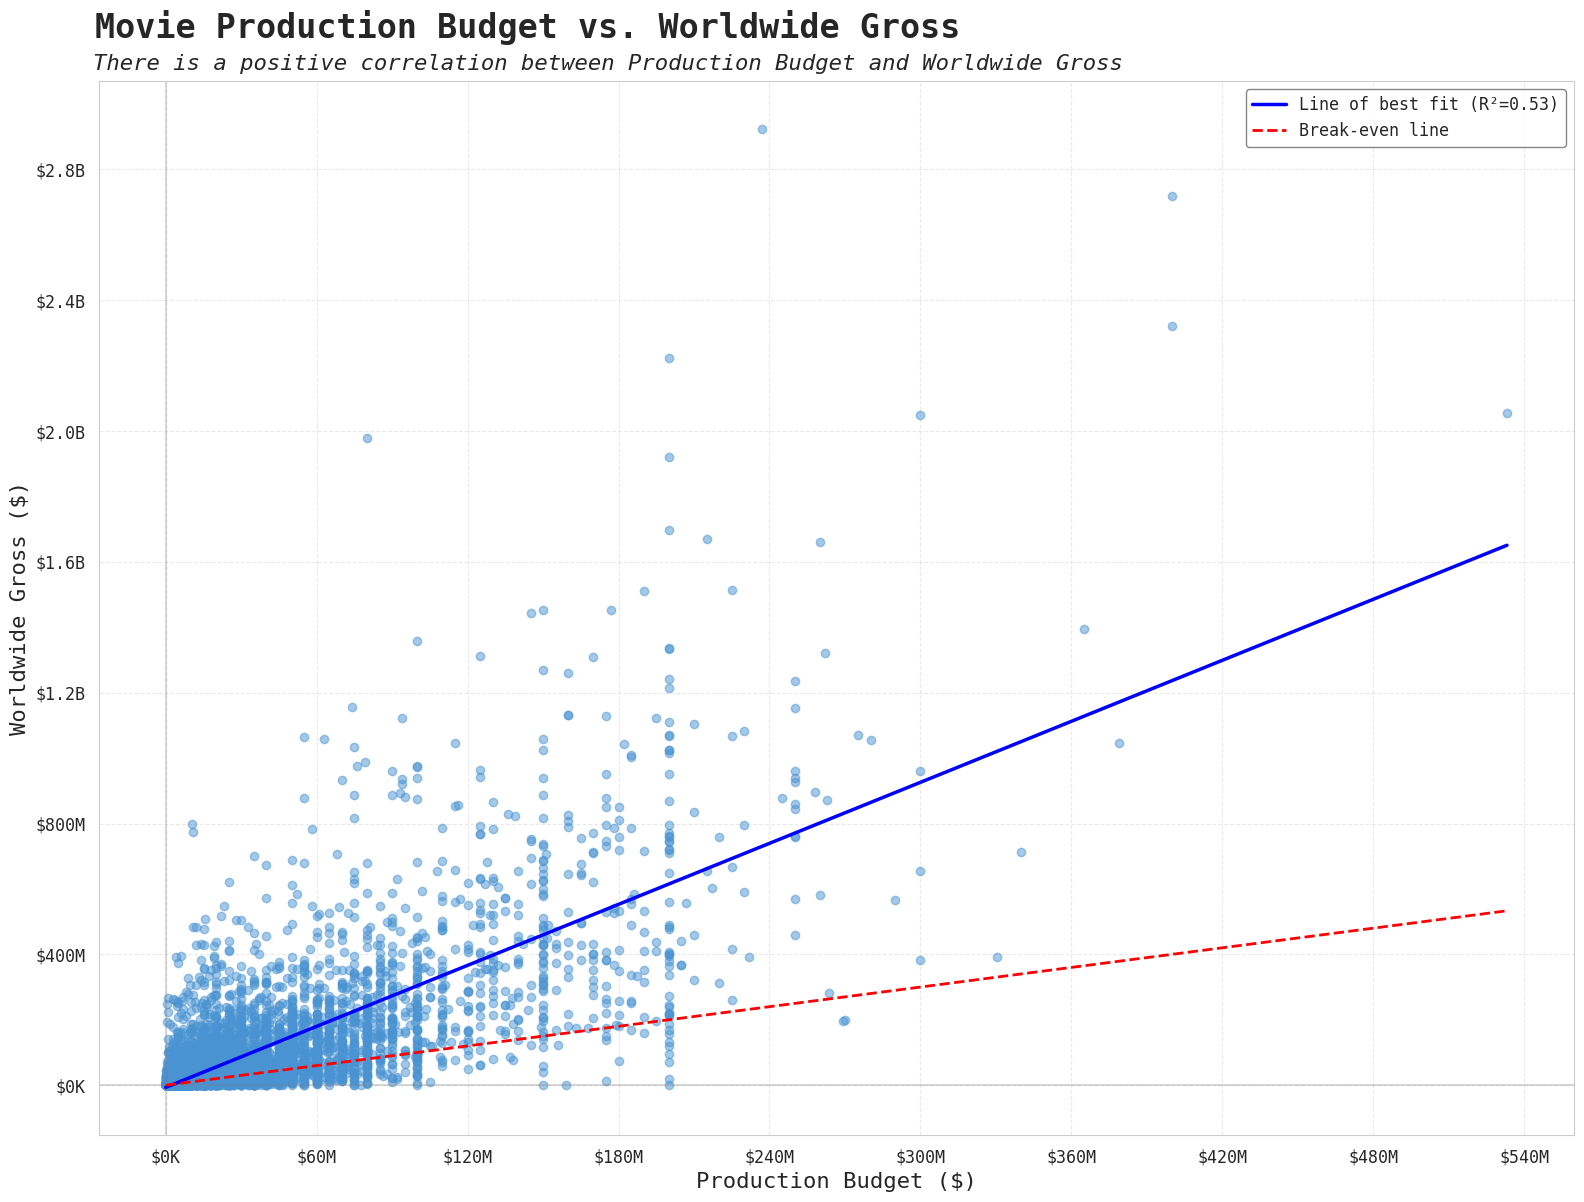

In [59]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.ticker as ticker

def set_chart_style():
    # Set the global font to monospace
    plt.rcParams['font.family'] = 'monospace'
    
    # Figure size and DPI
    plt.figure(figsize=(16, 12), dpi=100)
    
    # Grid settings
    plt.grid(True, linestyle='--', alpha=0.3)
    
    # Add horizontal and vertical lines at origin
    plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='gray', linestyle='-', alpha=0.3)
    
    # Font sizes for various elements
    plt.rcParams['font.size'] = 12
    plt.rcParams['axes.titlesize'] = 24
    plt.rcParams['axes.labelsize'] = 16
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12
    plt.rcParams['legend.fontsize'] = 12
    
    # Tick parameters
    plt.tick_params(axis='both', which='major', labelsize=12, direction='out', length=6, width=1)
    
    # Spines
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.right'] = False
    
    # Set seaborn style
    sns.set_style("whitegrid")
    
    return plt

plt = set_chart_style()

# Create scatter plot
plt.scatter(df['production_budget'], df['worldwide_gross'], alpha=0.5, color='#4993D2')

# Add line of best fit
slope, intercept, r_value, p_value, std_err = stats.linregress(df['production_budget'], df['worldwide_gross'])
x = np.array([min(df['production_budget']), max(df['production_budget'])])
y = slope * x + intercept
plt.plot(x, y, '-', color='blue', linewidth=2.5, label=f'Line of best fit (R²={r_value**2:.2f})')

# Add break-even line
plt.plot([0, max(df['production_budget'])], [0, max(df['production_budget'])], '--', 
         color='red', linewidth=2, label='Break-even line')

# Add title and labels
fig = plt.gcf()
fig.suptitle('Movie Production Budget vs. Worldwide Gross', 
             fontweight='bold', 
             fontsize=24, 
             fontfamily='monospace',
             y=1, x=0.335)  # Position from the top (0-1 range)

# Add subtitle
plt.figtext(0.385, 0.95,  # x position, y position (0-1 range) 
            'There is a positive correlation between Production Budget and Worldwide Gross',
            ha='center',  # horizontal alignment
            fontsize=16, 
            fontfamily='monospace',
            style='italic')

# You might need to adjust the layout to make room for both
plt.subplots_adjust(top=0.7)
plt.xlabel('Production Budget ($)')
plt.ylabel('Worldwide Gross ($)')

# Format tick labels to show millions/billions
def millions_formatter(x, pos):
    if x >= 1e9:
        return f'${x/1e9:.1f}B'
    elif x >= 1e6:
        return f'${x/1e6:.0f}M'
    else:
        return f'${x/1e3:.0f}K'

# Apply the formatter to both axes
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))

# Increase tick frequency for better readability
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(10))
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(10))

# Make the grid lighter but still visible
plt.grid(True, linestyle='--', alpha=0.4)

# Create a more styled legend with monospace font
legend = plt.legend(frameon=True, framealpha=0.95, edgecolor='gray', 
                   fontsize=12, loc='upper right')

# Explicitly set the font family for the legend text
for text in legend.get_texts():
    text.set_fontfamily('monospace')

plt.tight_layout()
plt.show()

In [23]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Scale the data (divide by 1 million to convert to millions)
X = df['production_budget'] / 1_000_000  # Convert to millions
X = sm.add_constant(X)
y = df['worldwide_gross'] / 1_000_000  # Convert to millions

# Fit the model
model = sm.OLS(y, X).fit()

# Print the summary
print(model.summary())

# Access specific statistics
print("\nCoefficients:")
print(f"Intercept: {model.params['const']:.4f} million, p-value: {model.pvalues['const']:.4f}")
print(f"Production Budget (millions): {model.params['production_budget']:.4f}, p-value: {model.pvalues['production_budget']:.4f}")

                            OLS Regression Results                            
Dep. Variable:        worldwide_gross   R-squared:                       0.529
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     6741.
Date:                Tue, 29 Apr 2025   Prob (F-statistic):               0.00
Time:                        06:05:52   Log-Likelihood:                -37916.
No. Observations:                5999   AIC:                         7.584e+04
Df Residuals:                    5997   BIC:                         7.585e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -6.5696      2.20

### Multivariate Linear Regression

In [24]:
df["release_year"] = df["release_date"].dt.year
df["release_month"] = df["release_date"].dt.month

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


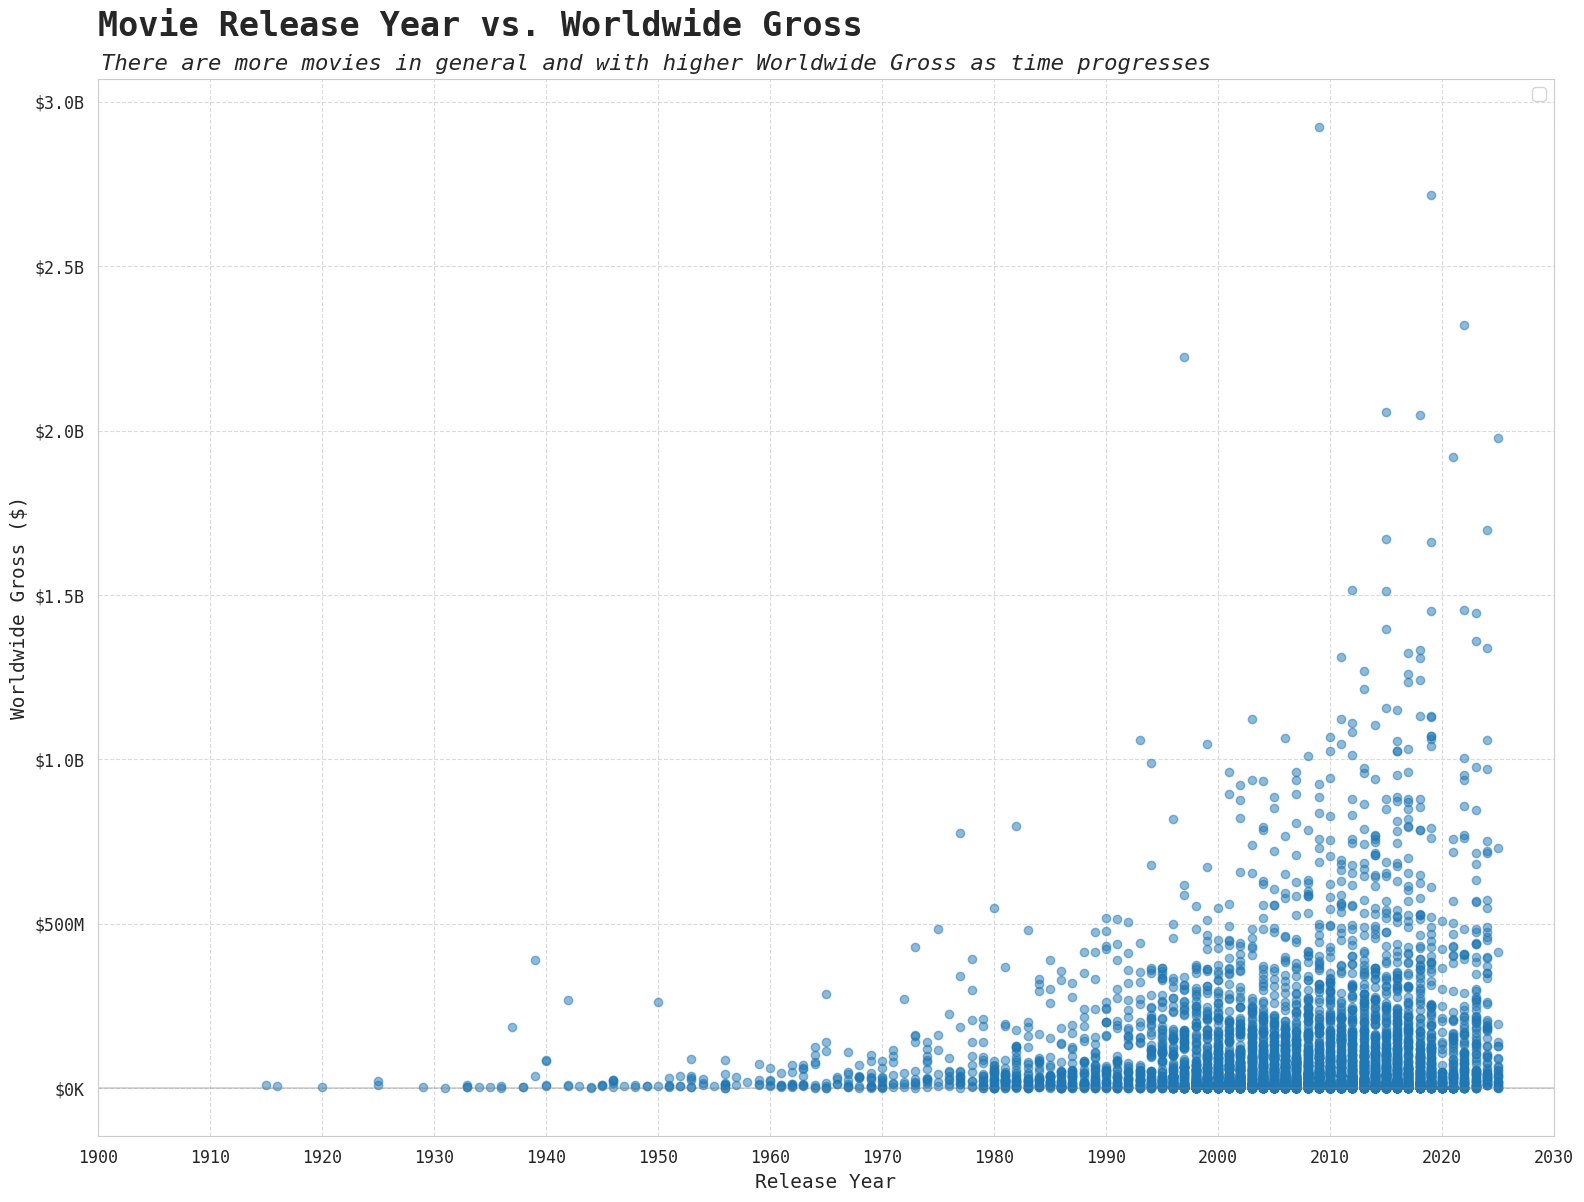

In [76]:
import matplotlib.ticker as ticker

plt = set_chart_style()

# Create scatter plot
plt.scatter(df['release_year'], df['worldwide_gross'], alpha=0.5)

# Add title and labels
fig = plt.gcf()
fig.suptitle('Movie Release Year vs. Worldwide Gross', 
             fontweight='bold', 
             fontsize=24, 
             fontfamily='monospace',
             y=1, x=0.305)  # Position from the top (0-1 range)

# Add subtitle
plt.figtext(0.415, 0.95,  # x position, y position (0-1 range) 
            'There are more movies in general and with higher Worldwide Gross as time progresses',
            ha='center',  # horizontal alignment
            fontsize=16, 
            fontfamily='monospace',
            style='italic')
plt.xlabel('Release Year', fontsize=14)
plt.ylabel('Worldwide Gross ($)', fontsize=14)

def millions_formatter(x, pos):
    if x >= 1e9:
        return f'${x/1e9:.1f}B'
    elif x >= 1e6:
        return f'${x/1e6:.0f}M'
    else:
        return f'${x/1e3:.0f}K'

# Apply the formatter to both axes
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))
plt.xlim(1900, 2030)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(10)) 

plt.grid(True, linestyle='--', alpha=0.7)
#plt.ticklabel_format(style='plain', axis='both')
plt.legend()
plt.tight_layout()
plt.show()

In [26]:
# Scale the data (divide by 1 million to convert to millions)
X = df[['release_year']]  # Include both variables
X = sm.add_constant(X)  # Add constant term
y = df['worldwide_gross'] / 1_000_000  # Convert to millions

# Fit the model
model = sm.OLS(y, X).fit()

# Print the summary
print(model.summary())

# Access specific statistics
print("\nCoefficients:")
print(f"Intercept: {model.params['const']:.4f} million, p-value: {model.pvalues['const']:.4f}")
print(f"Release Year: {model.params['release_year']:.4f}, p-value: {model.pvalues['release_year']:.4f}")

                            OLS Regression Results                            
Dep. Variable:        worldwide_gross   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     107.6
Date:                Tue, 29 Apr 2025   Prob (F-statistic):           5.47e-25
Time:                        06:05:52   Log-Likelihood:                -40123.
No. Observations:                5999   AIC:                         8.025e+04
Df Residuals:                    5997   BIC:                         8.026e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -3911.8355    387.269    -10.101   

In [27]:
# Scale the data (divide by 1 million to convert to millions)
X = df[['production_budget', 'release_year']]  # Include both variables
X['production_budget'] = X['production_budget'] / 1_000_000  # Convert to millions
X = sm.add_constant(X)  # Add constant term
y = df['worldwide_gross'] / 1_000_000  # Convert to millions

# Fit the model
model = sm.OLS(y, X).fit()

# Print the summary
print(model.summary())

# Access specific statistics
print("\nCoefficients:")
print(f"Intercept: {model.params['const']:.4f} million, p-value: {model.pvalues['const']:.4f}")
print(f"Production Budget (millions): {model.params['production_budget']:.4f}, p-value: {model.pvalues['production_budget']:.4f}")
print(f"Release Year: {model.params['release_year']:.4f}, p-value: {model.pvalues['release_year']:.4f}")

                            OLS Regression Results                            
Dep. Variable:        worldwide_gross   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     3382.
Date:                Tue, 29 Apr 2025   Prob (F-statistic):               0.00
Time:                        06:05:52   Log-Likelihood:                -37911.
No. Observations:                5999   AIC:                         7.583e+04
Df Residuals:                    5996   BIC:                         7.585e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               908.8711    274.41

C:\Users\Owner\AppData\Local\Temp\ipykernel_40900\2448496258.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['production_budget'] = X['production_budget'] / 1_000_000  # Convert to millions


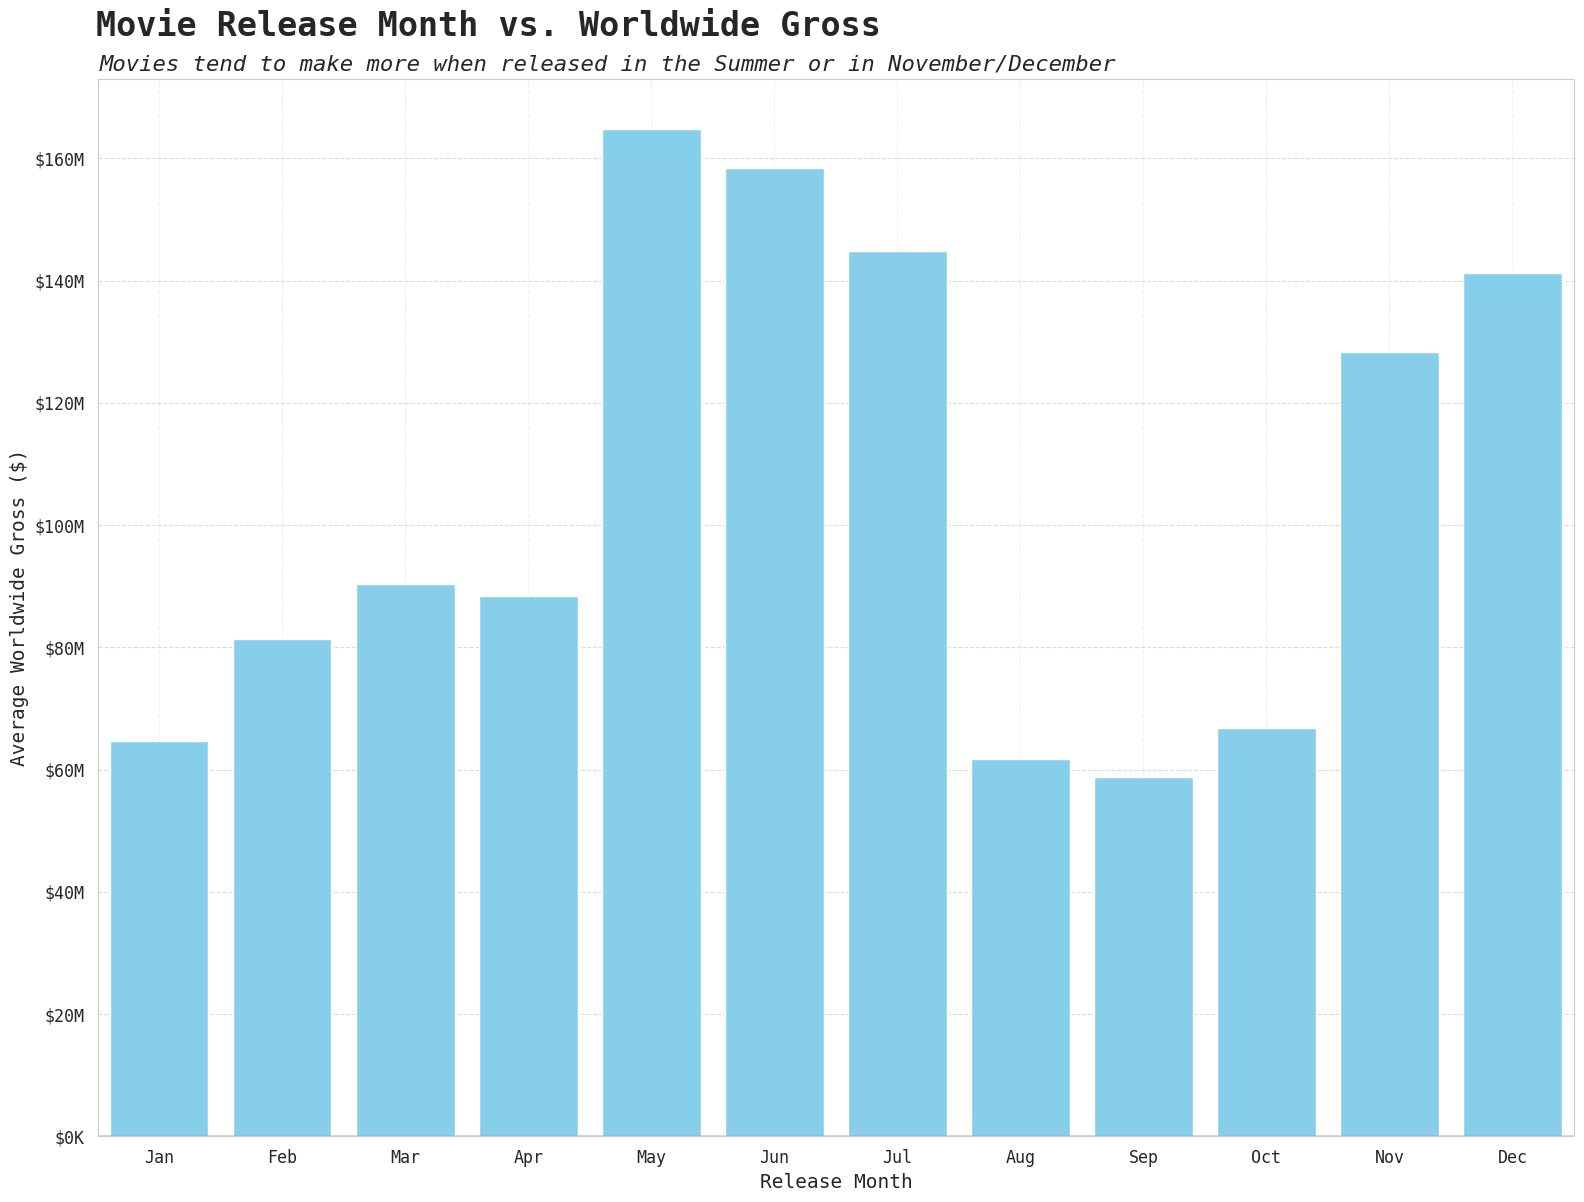

In [101]:
plt = set_chart_style()

# Group by month and calculate mean worldwide gross
monthly_avg = df.groupby('release_month')['worldwide_gross'].mean().reset_index()

# Create bar chart with positions that match your ticks
plt.bar(monthly_avg['release_month'], monthly_avg['worldwide_gross'], color='skyblue', alpha=1)

# Add title and labels with proper positioning
fig = plt.gcf()
fig.suptitle('Movie Release Month vs. Worldwide Gross', 
             fontweight='bold', 
             fontsize=24, 
             fontfamily='monospace', y=1, x=0.31)  # Remove manual positioning

# Add subtitle with centered positioning
plt.figtext(0.385, 0.95,  # x position centered (0.5)
            'Movies tend to make more when released in the Summer or in November/December',
            ha='center',  # horizontal alignment
            fontsize=16, 
            fontfamily='monospace',
            style='italic')

def millions_formatter(x, pos):
    if x >= 1e9:
        return f'${x/1e9:.1f}B'
    elif x >= 1e6:
        return f'${x/1e6:.0f}M'
    else:
        return f'${x/1e3:.0f}K'

# Apply the formatter to y-axis
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))
plt.xlabel('Release Month', fontsize=14)
plt.ylabel('Average Worldwide Gross ($)', fontsize=14)

# Format x-axis to show month names that align with your data
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(range(1, 13), months)

# Set the x-axis limits to match your data range
plt.xlim(0.5, 12.5)  # This ensures proper padding around the bars

plt.grid(True, linestyle='--', alpha=0.7, axis='y')
plt.tight_layout()
plt.show()

In [29]:

# Convert production_budget to numeric if it's not already
df['production_budget'] = pd.to_numeric(df['production_budget'], errors='coerce')

# Make sure release_year is numeric
df['release_year'] = pd.to_numeric(df['release_year'], errors='coerce')

# Calculate squared term after ensuring year is numeric
df['release_year_squared'] = df['release_year']**2

# Create dummy variables for months
month_dummies = pd.get_dummies(df['release_month'], prefix='month', drop_first=True)

# Drop any rows with NaN values after the conversions
df = df.dropna(subset=['release_year', 'production_budget', 'worldwide_gross'])

# Now create your feature matrix
X = pd.concat([df[['release_year', 'release_year_squared', 'production_budget']], month_dummies], axis=1)
X = sm.add_constant(X)
for col in X.columns:
    if X[col].dtype == 'bool':
        X[col] = X[col].astype(int)

# And your target variable
y = df['worldwide_gross'] / 1_000_000  # Convert to millions

# Fit the model
model = sm.OLS(y, X).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        worldwide_gross   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     491.1
Date:                Tue, 29 Apr 2025   Prob (F-statistic):               0.00
Time:                        06:05:52   Log-Likelihood:                -37881.
No. Observations:                5999   AIC:                         7.579e+04
Df Residuals:                    5984   BIC:                         7.589e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 5.092e+04 

In [30]:
df['covid'] = ((df['release_year'] == 2020) & (df['release_month'] >= 3)) | (df['release_year'] == 2021)

# Include it in your model
X = pd.concat([
    X[['const', 'release_year', 'release_year_squared', 'production_budget', 
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12']],
    df['covid']
], axis=1)
for col in X.columns:
    if X[col].dtype == 'bool':
        X[col] = X[col].astype(int)

# Run the regression
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        worldwide_gross   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.536
Method:                 Least Squares   F-statistic:                     462.8
Date:                Tue, 29 Apr 2025   Prob (F-statistic):               0.00
Time:                        06:05:52   Log-Likelihood:                -37865.
No. Observations:                5999   AIC:                         7.576e+04
Df Residuals:                    5983   BIC:                         7.587e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 7.125e+04 

In [31]:
df['non_us_release'] = (df['domestic_gross'] == 0).astype(int)

# Add to your model
X = pd.concat([
    X[['const', 'release_year', 'release_year_squared', 'production_budget', 
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'covid']],
    df['non_us_release']
], axis=1)

# Run the regression
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        worldwide_gross   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     436.0
Date:                Tue, 29 Apr 2025   Prob (F-statistic):               0.00
Time:                        06:05:52   Log-Likelihood:                -37857.
No. Observations:                5999   AIC:                         7.575e+04
Df Residuals:                    5982   BIC:                         7.586e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 7.894e+04 

In [32]:
# Create interaction term
df['budget_year_interaction'] = df['production_budget'] * df['release_year'] 

# Add to your model
X = pd.concat([
    X[['const', 'release_year', 'release_year_squared', 'production_budget', 
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'covid',
       'non_us_release']],
    df['budget_year_interaction']
], axis=1)

# Use log transformation on the dependent variable
# Add small constant to handle zeros if needed
y = df['worldwide_gross'] / 1_000_000  # Convert to millions

# Run the regression
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        worldwide_gross   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     438.2
Date:                Tue, 29 Apr 2025   Prob (F-statistic):               0.00
Time:                        06:05:52   Log-Likelihood:                -37849.
No. Observations:                5999   AIC:                         7.573e+04
Df Residuals:                    5982   BIC:                         7.585e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

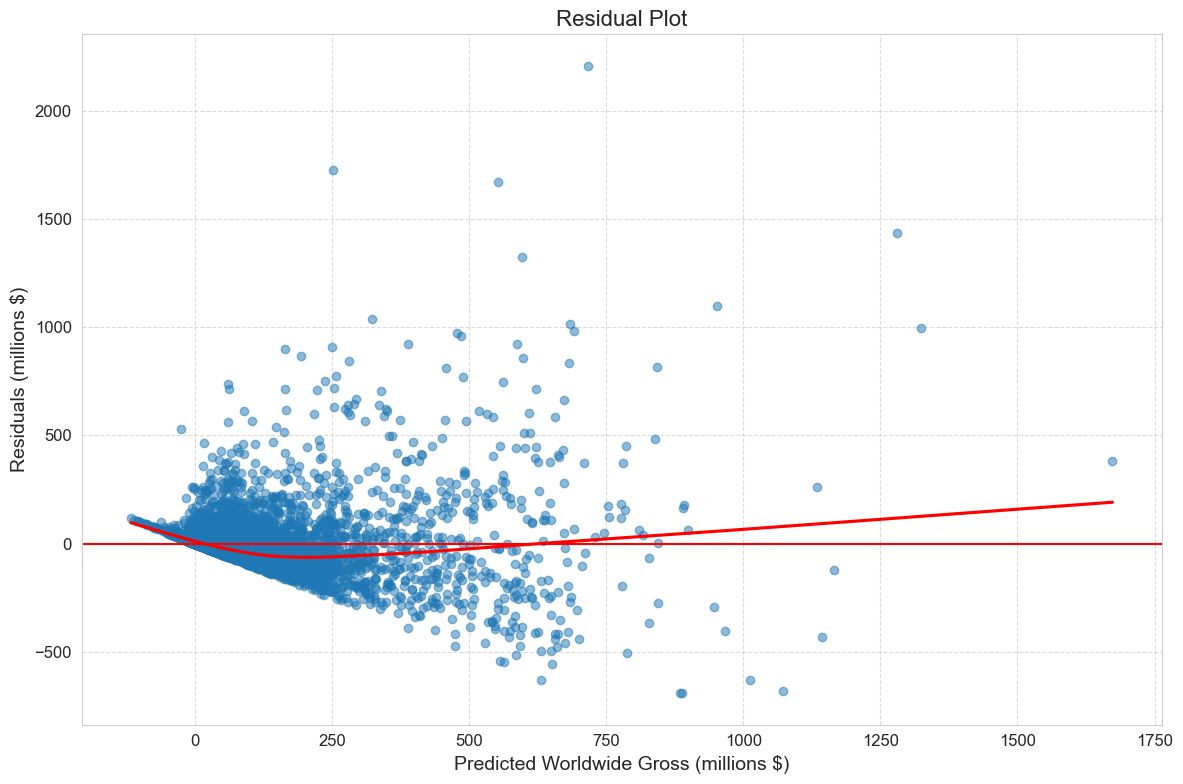

In [33]:
import seaborn as sns

# Calculate residuals if you haven't already
df['predicted_gross'] = model.predict(X)
df['residual'] = df['worldwide_gross']/1_000_000 - df['predicted_gross']

# Create residual plot
plt.figure(figsize=(12, 8))

# Scatter plot of residuals vs predicted values
plt.scatter(df['predicted_gross'], df['residual'], alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-')

# Add a lowess smoothed line to see patterns
sns.regplot(x=df['predicted_gross'], y=df['residual'], 
            scatter=False, lowess=True, line_kws={'color': 'red'})

# Add labels and title
plt.xlabel('Predicted Worldwide Gross (millions $)', fontsize=14)
plt.ylabel('Residuals (millions $)', fontsize=14)
plt.title('Residual Plot', fontsize=16)

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)

# Improve layout
plt.tight_layout()

# Show plot
plt.show()

In [34]:
# Get predictions from your model
df['predicted_gross'] = model.predict(X)

# Calculate residuals (actual - predicted)
df['residual'] = df['worldwide_gross']/1_000_000 - df['predicted_gross']

# Find the biggest overperformers (highest positive residuals)
overperformers = df.sort_values(by='residual', ascending=False).head(20)

# View the top overperformers
print("Top 10 Overperformers:")
print(overperformers[['Movie', 'release_year', 'production_budget', 'worldwide_gross', 'predicted_gross', 'residual']])

Top 10 Overperformers:
                                              Movie  release_year  \
6562                                         Avatar          2009   
5886                             Ne Zha 2 (哪吒之魔童闹海)          2025   
6587                                        Titanic          1997   
6526                              Avengers: Endgame          2019   
6585                        Spider-Man: No Way Home          2021   
6533                         Avengers: Infinity War          2018   
6194                    The Super Mario Bros. Movie          2023   
6588                                   Inside Out 2          2024   
6527                       Avatar: The Way of Water          2022   
6575                                 Jurassic World          2015   
6349                                      Frozen II          2019   
6402                                         Barbie          2023   
6441                                      Furious 7          2015   
6273  Harry

In [102]:
actual = df[df['Movie'] == 'Avatar']['worldwide_gross'].values[0]
predicted = int(df[df['Movie'] == 'Captain Fantastic']['predicted_gross'].values[0] * 1_000_000)
difference = actual - predicted

# Format numbers with commas for better readability
print(f"${actual:,}, ${predicted:,}, ${difference:,}")

$2,923,706,026, $23,411,526, $2,900,294,500
